In [50]:
# visualization - compare with physics-based model (CAMS) + emission

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from datetime import datetime, timedelta


In [51]:
# read data
path_eac4 = "/HDD/global/EAC4_pm2p5_aod550/global_2019-2022.nc"
path_refer = "/HDD/global/refer/refer-{}.npy"
# path_pred = "/DATA/global-emission-2/pred/start_{}/pred-{}.npy"
# path_pred = "/DATA/global-emission/pred/nlag1_{}h/pred-*.npy"
path_pred = '/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy'
# path_dann = "/DATA/dann_test/nlag1_{}h/da-{}.npy"
path_dann = "/DATA/dann_test_2018_tempo/start_{}/da-{}.npy"
# path_cams = "/DATA/CAMS/cams_resample/start_{}/cams-{}.npy"       #5-days-ahead prediction
path_fig = '/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/'

In [52]:
nc_file_eac4 = nc.Dataset(path_eac4)
times_nc = nc_file_eac4.variables['time']
nt = len(times_nc)
lon_eac4 = nc_file_eac4.variables['longitude'][:]
lat_eac4 = nc_file_eac4.variables['latitude'][:]
lon_eac4_grid, lat_eac4_grid = np.meshgrid(lon_eac4, lat_eac4)
nx, ny = lon_eac4_grid.shape

# use data on 2018 for training and validation
dates_eac4 = nc.num2date(times_nc[:], times_nc.units, calendar=times_nc.calendar)
formated_dates_eac4 = [date.strftime('%Y-%m-%d %H:%M:%S') for date in dates_eac4]
print('training & validation:', formated_dates_eac4[0], '--', formated_dates_eac4[-1])

training & validation: 2019-01-01 00:00:00 -- 2022-12-31 21:00:00


In [53]:
# calculate mean and variance of PM2.5 and AOD550 prediciton over all available times
# since we are going to reuse CAMS preficiton for validation many times, 
# spatial resample and save it in a seperate file

import glob
import re
from datetime import datetime

n_ahead = 40+1

RMSE_pred = np.empty((n_ahead, 100))
ACC_pred = np.empty((n_ahead, 100))

RMSE_dann = np.empty((n_ahead, 100))
ACC_dann = np.empty((n_ahead, 100))

start_files = files_pred0 = sorted(list(glob.glob("/DATA/dann_test_2018_tempo/start_*")))

i_file = 0
for start_file in start_files:
        
    start_str = start_file.split('_')[-1]
    start_date = datetime.strptime(start_str, '%Y%m%d%H')
    
    for ahead in range(n_ahead):
        
        current_date = start_date + timedelta(hours=ahead*3)
        
        # reference
        filename = path_refer.format(current_date.strftime('%Y%m%d%H'))
        print(filename)
        refer = np.load(filename)[...,1]
        
        # pred
        filename = path_pred.format(start_date.strftime('%Y%m%d%H'), current_date.strftime('%Y%m%d%H'))
        print(filename)
        pred = np.load(filename)[...,1]
        
        # da
        filename = path_dann.format(start_date.strftime('%Y%m%d%H'), current_date.strftime('%Y%m%d%H'))
        print(filename)
        dann = np.load(filename)
    
        print(i_file, np.sqrt(np.mean((refer - pred)**2)))
        RMSE_pred[ahead, i_file] = np.sqrt(np.mean((refer - pred)**2))
        ACC_pred[ahead, i_file] = np.corrcoef(refer.flatten(), pred.flatten())[0, 1]**2
        
        RMSE_dann[ahead, i_file] = np.sqrt(np.mean((refer - dann)**2))
        ACC_dann[ahead, i_file] = np.corrcoef(refer.flatten(), dann.flatten())[0, 1]**2
        
        # # mean and variance
        # RMSE_pred[ahead, 0, :] = np.mean(rmse_pred_nt, axis=0)
        # RMSE_pred[ahead, 1, :] = np.sqrt(np.var(rmse_pred_nt, axis=0))
    
    i_file = i_file + 1
        
        

/HDD/global/refer/refer-2019010100.npy
(241, 480)
/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_2019010100/pred-2019010100.npy
(241, 480)
/DATA/dann_test_2018_tempo/start_2019010100/da-2019010100.npy
(241, 480)
0 0.06879343735692942
/HDD/global/refer/refer-2019010103.npy
(241, 480)
/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_2019010100/pred-2019010103.npy
(241, 480)
/DATA/dann_test_2018_tempo/start_2019010100/da-2019010103.npy
(241, 480)
0 0.061968866720703106
/HDD/global/refer/refer-2019010106.npy
(241, 480)
/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_2019010100/pred-2019010106.npy
(241, 480)
/DATA/dann_test_2018_tempo/start_2019010100/da-2019010106.npy
(241, 480)
0 0.05934173641922956
/HDD/global/refer/refer-2019010109.npy
(241, 480)
/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_2019010100/pred-2019010109.npy
(241, 480)
/DATA/dann_test_2018_tempo/start_2019010100/da-2019010109.npy
(241, 480)
0 0.058726069146771295
/HDD/global/refer/refer-2019010112

IndexError: index 100 is out of bounds for axis 1 with size 100

/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures2_iAOD/metrics_dann_ave_aod550.png


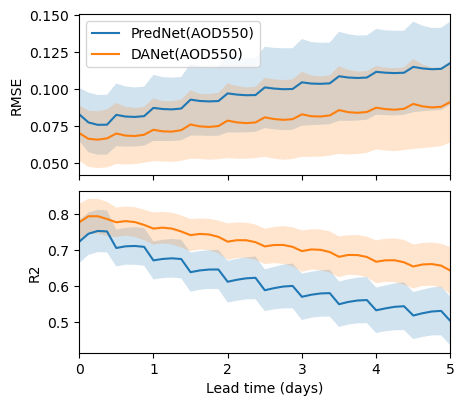

In [55]:
# PM2.5 prediction

# 1/4 page figure = 95 mm x 115 mm
# Full page = 190 mm x 230 mm

figure_width_mm = 115
figure_height_mm = 100

# Convert mm to inches
figure_width_inches = figure_width_mm / 25.4
figure_height_inches = figure_height_mm / 25.4

features = ['pm2p5', 'aod550']
titles = ['Metrics-PM2.5', 'Metrcis-AOD550']
ylabels = ['RMSE ($ug/m3$)', 'RMSE']
scale = [1e9, 1]

nt = 41

fig, axs = plt.subplots(2, 1, figsize=(figure_width_inches, figure_height_inches), sharex=True)

x = np.arange(41)*3/24

index = 1

y_mean = np.mean(RMSE_pred, axis=1)*scale[index]
y_std = np.sqrt(np.var(RMSE_pred, axis=1))*scale[index]
axs[0].plot(x,y_mean, label='PredNet(AOD550)')
axs[0].fill_between(x, y_mean-y_std, y_mean+y_std, alpha=0.2)  # Grey shaded variance

y_mean = np.mean(RMSE_dann, axis=1)*scale[index]
y_std = np.sqrt(np.var(RMSE_dann, axis=1))*scale[index]
axs[0].plot(x,y_mean, label='DANet(AOD550)')
axs[0].fill_between(x, y_mean-y_std, y_mean+y_std, alpha=0.2)  # Grey shaded variance
axs[0].set_ylabel(ylabels[index])
axs[0].legend(loc='upper left')

y_mean = np.mean(ACC_pred, axis=1)*scale[index]
y_std = np.sqrt(np.var(ACC_pred, axis=1))*scale[index]
axs[1].plot(x,y_mean)
axs[1].fill_between(x, y_mean-y_std, y_mean+y_std, alpha=0.2, label='Variance')  # Grey shaded variance

y_mean = np.mean(ACC_dann, axis=1)*scale[index]
y_std = np.sqrt(np.var(ACC_dann, axis=1))*scale[index]
axs[1].plot(x,y_mean)
axs[1].fill_between(x, y_mean-y_std, y_mean+y_std, alpha=0.2, label='Variance')  # Grey shaded variance
axs[1].set_ylabel('R2')
axs[1].set_xlabel('Lead time (days)')
axs[1].set_xlim(0,5)

# axs[0].set_xlim(1,2)

plt.subplots_adjust(wspace=0.02, hspace=0.1, left=0.16, right=0.98, top=0.98, bottom=0.12)

filename = path_fig+ 'metrics_dann_ave_{}.png'.format(features[index])
print(filename)
fig.savefig(filename, dpi=300)

plt.show()